In [1]:
%matplotlib inline

import collections
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import sklearn.metrics
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Convolutional neural networks

Up to now we've been processing text such that the neural network was looking at the entire text all at once, either as a bag of words or as a sequence of tokens, such that the number of parameters in the model depends on each token.
This is very parameter inefficient, which leads to longer training time and overfitting.
A better way is to only look at a small chunk of tokens at once and do something with them before looking at the next chunk of tokens.
The number of parameters required in this way depends on the number of tokens in the chunk rather than in the text, which is more reasonable and is closer to how people read.
In this topic we'll see how to do this using a mathematical operator called the **convolution operation**.

## The convolution operator

The **convolution operator** is a mathematical operator that takes two tensors, the **input tensor** and the smaller **kernel tensor**, and produces a **resultant tensor**.
Imagine the kernel tensor sliding over the input tensor.
As the kernel slides over the input, the **dot product** (sum of products of corresponding numbers) of the overlapping numbers is appended to the resultant tensor.
Below is an example using two vectors:

![](simple_conv.png)

The width of the kernel, or amount of numbers seen at once, is called the **window size**.
Note how the resultant vector is one number shorter than the input vector.
Having a smaller resultant tensor is normal in convolution operations.

In NumPy, this function is called `correlate` (a signal processing term):

In [2]:
input_ = np.array([1, 2, 3, 4], np.float32)
kernel = np.array([1, 2], np.float32)
print(np.correlate(input_, kernel))

[ 5.  8. 11.]


In PyTorch you don't slide over a list of scalars like in NumPy, but over a list of vectors (such as token vectors).
We'll need to use 3D tensors for the inputs.
These three dimensions are

* the number of texts in the batch by
* the number of token in each text by
* the token vector size (the size of the vectors).

We'll also need 3D tensors for the kernel.
The three dimensions are

* the window size by
* the vector size in the input tensor by
* the vector size in the resultant tensor.

The kernel does not perform a dot product to the part of the input it is sliding over but performs a matrix multiplication.
This is so that the resultant tensor can have a differently sized vector than the vectors in the input tensor.

Also, the vector size is called the number of **channels** (a term from image processing).

Here's an illustration showing how this works:

![](complex_conv.png)

Note how we started with vector sizes of 3 and ended up with vector sizes of 4.
Also note that if the number of texts was more than one, the same operation would be computed on each text separately.

In PyTorch this is done using the `torch.nn.Conv1d` layer:

In [3]:
input_ = torch.tensor([
    [
        [1 , 2 , 3 ],
        [4 , 5 , 6 ],
        [7 , 8 , 9 ],
        [10, 11, 12],
    ],
], dtype=torch.float32, device=device)

layer = torch.nn.Conv1d(3, 4, 2) # input vector size, output vector size, window size
layer.to(device)

print(layer(input_.transpose(1, 2)).transpose(1, 2))

tensor([[[-1.1780, -0.7316,  0.4592,  3.3771],
         [-2.3428, -1.1487,  0.5295,  6.4880],
         [-3.5076, -1.5658,  0.5999,  9.5988]]], grad_fn=<TransposeBackward0>)


A Conv1d layer is an actual neural layer, called a **convolutional layer**, that replaces the matrix-multiplication of the weight matrix in a linear layer with a convolution operation of a kernel 3D tensor.
A bias is also used which is added to the resultant vector.

You're surely wondering what those `transpose` functions are doing there.
A transpose operation is used to swap two dimensions in a tensor, such as the rows and columns of a matrix.

In [4]:
x = np.array([[1, 2, 3], [4, 5, 6]])
print('x')
print(x)
print()
print('x transposed')
print(x.T)

x
[[1 2 3]
 [4 5 6]]

x transposed
[[1 4]
 [2 5]
 [3 6]]


Unfortunately, convolutions in PyTorch are a bit weird in that they require the dimensions of the input and resultant to be in the following orders:

Input -

* the number of texts in the batch by
* the token vector size (the size of the vectors) by
* the number of tokens in the text.

Resultant -

* the number of texts in the batch by
* output vector size by
* the number of vectors returned.

Since this order is not intuitive, it's more readable to perform a transpose operation on an intuitively ordered input tensor and then transpose the resultant tensor into a sensible order.

The transpose operation in PyTorch can be made on a tensor of any number of dimensions and you just need to provide the indexes of the dimensions to swap:

In [5]:
input_ = torch.tensor([
    [
        [1 , 2 , 3 ],
        [4 , 5 , 6 ],
        [7 , 8 , 9 ],
        [10, 11, 12],
    ],
    [
        [13, 14, 15],
        [16, 17, 18],
        [19, 20, 21],
        [22, 23, 24],
    ],
], dtype=torch.float32, device=device)

print('input')
print(input_.shape)
print(input_)
print()

x = input_.transpose(1, 2)
print('input.transpose(1, 2)')
print(x.shape)
print(x)

input
torch.Size([2, 4, 3])
tensor([[[ 1.,  2.,  3.],
         [ 4.,  5.,  6.],
         [ 7.,  8.,  9.],
         [10., 11., 12.]],

        [[13., 14., 15.],
         [16., 17., 18.],
         [19., 20., 21.],
         [22., 23., 24.]]])

input.transpose(1, 2)
torch.Size([2, 3, 4])
tensor([[[ 1.,  4.,  7., 10.],
         [ 2.,  5.,  8., 11.],
         [ 3.,  6.,  9., 12.]],

        [[13., 16., 19., 22.],
         [14., 17., 20., 23.],
         [15., 18., 21., 24.]]])


Note how all we're doing to the input and resultant tensors is transpose each matrix in the 3D tensor, that is, making the token vectors be columns instead of rows.
The order of the texts in the input is not affected at all.

## The convolutional neural network with a vector pooling layer

A neural network whose hidden layers mainly consist of convolutional layers is called a **convolutional neural network** (**CNN**).
Convolutional neural networks have been extensively used for images, but they are also used for text to a lesser extent.
The trouble with convolutional layers is that they return a matrix for each text rather than a vector, which needs to somehow be transformed into a vector before it can be passed into a softmax for classification.
In the previous topic, we solved this by flattening the matrix such that all the rows were placed side by side as a single vector, but this forces us to have a fixed number of tokens.

A better method than flattening in order to turn a matrix of row vectors into a single vector is to use vector pooling.
This is when a bunch of vectors are aggregated into a single vector by either taking the minimum values of each corresponding element in the vectors, called min pooling, or taking the maximum values, called max pooling.
Here is an illustration of min pooling:

![](pooling.png)

Note that the vectors at the top are token (or window) vectors forming a single text and we transformed a bunch of vectors into a single vector representing the entire text.

Here is how to do this in PyTorch:

In [6]:
x = torch.randn((2, 3, 4), device=device)
print('2 texts with 3 token vectors')
print(x)
print()

print('max pooled')
(max_values, _) = torch.max(x, dim=1)
print(max_values)
print()

print('min pooled')
(min_values, _) = torch.min(x, dim=1)
print(min_values)

2 texts with 3 token vectors
tensor([[[ 1.4199, -0.3485, -0.7392, -0.0578],
         [ 1.4997,  0.2086,  2.3150,  0.2089],
         [ 0.2680,  0.2394, -0.8551, -0.5382]],

        [[-0.4834,  1.4276,  0.3755,  0.6827],
         [-0.3089, -0.8098,  1.1748,  0.2378],
         [-0.7522,  1.8504, -2.2459,  0.1056]]])

max pooled
tensor([[ 1.4997,  0.2394,  2.3150,  0.2089],
        [-0.3089,  1.8504,  1.1748,  0.6827]])

min pooled
tensor([[ 0.2680, -0.3485, -0.8551, -0.5382],
        [-0.7522, -0.8098, -2.2459,  0.1056]])


This means that the vector representing the entire text will always be represented by a vector having the size of a single token (or window) vector, regardless of how many tokens are in the text.
So now, after training, we can pass a sentence with more tokens or less tokens to the model and the neural network will still work.

This doesn't mean that can do away with pad tokens because we're still passing a whole batch of texts at once, and if those texts are not all the same length then we need to use pad tokens to make a regularly shaped tensor (we can't have a [jagged array](https://en.wikipedia.org/wiki/Jagged_array) as a tensor).
So pad tokens will be in the input and will be affecting the vector that comes out the other end of a pooling function.
Now this wasn't a problem for **fixed-size input models**, because a text would always have the same number of pad tokens appended to it.
But for **variable-sized input models** this will cause problems because the same text can have any number of pad tokens attached, depending on which other texts are included in its batch.
So it's important that we somehow make the model ignore the windows containing pad tokens.

<table>
    <tr><th>Text</th><td>the dog bit the cat PAD PAD</td></tr>
    <tr><th>Windows</th><td>the dog | dog bit | bit the | the cat | cat PAD | PAD PAD</td></tr>
    <tr><th>Filtered windows</th><td>the dog | dog bit | bit the | the cat</td></tr>
</table>

We can do this by substituting the numbers in the window vectors containing pad tokens with infinity when using min pooling, or negative infinity when using max pooling.
The window vectors will still be there, but the result of the pool function will not be affected by them.
This is a form of masking (like in dropout):

<table>
    <tr><th>Text</th><td>the dog bit the cat PAD PAD</td></tr>
    <tr><th>Windows</th><td>the dog | dog bit | bit the | the cat | cat PAD | PAD PAD</td></tr>
    <tr><th>Window vectors</th><td>[[1, -1], [2, -2], [3, -3], [4, -4], [5, -5], [6, -6]]</td></tr>
    <tr><th>Masked window vectors</th><td>[[1, -1], [2, -2], [3, -3], [4, -4], [&infin;, &infin;], [&infin;, &infin;]]</td></tr>
    <tr><th>Min pool</th><td>[1, -4]</td></tr>
</table>

You can do this by using `masked_fill`:

In [7]:
x = torch.randn((1, 3, 2), device=device)
print('1 text with 3 token vectors')
print(x)
print()

pad_mask = torch.tensor([ # Tells you which values to replace in the input tensor.
    [[0, 0], [0, 0], [1, 1]],
], dtype=torch.bool, device=device)
print('pad_mask')
print(pad_mask)
print()

masked = x.masked_fill(pad_mask, float('inf'))
print('masked')
print(masked)
print()

(pooled, _) = torch.min(masked, dim=1)
print('min pooled')
print(pooled)

1 text with 3 token vectors
tensor([[[-0.7910, -0.2015],
         [-1.1737,  0.9525],
         [ 0.9410,  0.1220]]])

pad_mask
tensor([[[False, False],
         [False, False],
         [ True,  True]]])

masked
tensor([[[-0.7910, -0.2015],
         [-1.1737,  0.9525],
         [    inf,     inf]]])

min pooled
tensor([[-1.1737, -0.2015]])


The pad mask is essential here.
We need it to have the same shape as the resultant tensor and to have `True` wherever a window would contain even a single pad token.
We can produce one if we know the length of the unpadded texts as follows:

In [8]:
max_len = 4
window_size = 2
text_lens = [
    1,
    2,
    3,
    4,
]
num_texts = len(text_lens)

embed_size = 2
out_size = 2
layer = torch.nn.Conv1d(embed_size, out_size, window_size)
layer.to(device)

embedded = torch.randn((num_texts, max_len, embed_size), device=device)
print('embedded.shape:')
print(embedded.shape)
print()

convolved = layer(embedded.transpose(1, 2)).transpose(1, 2)
print('convolved.shape:')
print(convolved.shape)
print()

num_windows = max_len - window_size + 1
pad_mask_np = np.ones((num_texts, num_windows), dtype=np.bool_) # Full of the value True.
for i in range(num_texts):
    pad_mask_np[i, :text_lens[i] - window_size + 1] = False # The first text_len - window_size + 1 windows do not contain a pad token.
pad_mask = torch.tensor(pad_mask_np, device=device)

print('pad_mask:')
print(pad_mask)
print()

pad_mask = pad_mask[:, :, None]
print('3D pad_mask:')
print(pad_mask)
print()

masked = convolved.masked_fill(pad_mask, float('inf'))
print('masked:')
print(masked)

embedded.shape:
torch.Size([4, 4, 2])

convolved.shape:
torch.Size([4, 3, 2])

pad_mask:
tensor([[ True,  True,  True],
        [False,  True,  True],
        [False, False,  True],
        [False, False, False]])

3D pad_mask:
tensor([[[ True],
         [ True],
         [ True]],

        [[False],
         [ True],
         [ True]],

        [[False],
         [False],
         [ True]],

        [[False],
         [False],
         [False]]])

masked:
tensor([[[    inf,     inf],
         [    inf,     inf],
         [    inf,     inf]],

        [[-0.1729,  0.4912],
         [    inf,     inf],
         [    inf,     inf]],

        [[ 2.1480, -0.8487],
         [ 1.0317,  0.7237],
         [    inf,     inf]],

        [[ 0.7158, -0.5111],
         [ 0.4219,  0.1313],
         [ 0.6741, -0.0310]]], grad_fn=<MaskedFillBackward0>)


There are two things to notice here:

First, the mask needs to be a 3D tensor in order to be used on a 3D tensor.
Simply adding a singleton dimension at the end will make it compatible with a 3D tensor of any third dimension size (window vector size).
This very useful feature (saves memory) is called **broadcasting**.

Second, note that a window size of 2 assumes that the text will contain at least 2 tokens.
For a text that contains just 1 token, the first window will have a pad token in it and will be masked as well.
This will create problems as the pooling function will end up having nothing but infinities in its input and will thus output infinities, which will get passed to the next layer.
In short, the window size is the minimum text size and you should not accept any texts that have less tokens than the window size.

Let's solve the toy data set with a the convolutional neural network and min pooling.

In [9]:
train_x = [
    'I like it .'.split(' '),
    'I hate it .'.split(' '),
    'I don\'t hate it .'.split(' '),
    'I don\'t like it .'.split(' '),
]
train_y = torch.tensor([
    [1],
    [0],
    [1],
    [0],
], dtype=torch.float32, device=device)

text_lens = [len(text) for text in train_x]
print('text_lens:', text_lens)

max_len = max(text_lens)
print('max_len:', max_len)

vocab = ['<PAD>'] + sorted({token for text in train_x for token in text})
token2index = {t: i for (i, t) in enumerate(vocab)}
pad_index = token2index['<PAD>']
print('vocab:', vocab)
print()

train_x_indexed_np = np.full((len(train_x), max_len), pad_index, np.int64)
for i in range(len(train_x)):
    for j in range(len(train_x[i])):
        train_x_indexed_np[i, j] = token2index[train_x[i][j]]
train_x_indexed = torch.tensor(train_x_indexed_np, device=device)
print('train_x_indexed:')
print(train_x_indexed)

text_lens: [4, 4, 5, 5]
max_len: 5
vocab: ['<PAD>', '.', 'I', "don't", 'hate', 'it', 'like']

train_x_indexed:
tensor([[2, 6, 5, 1, 0],
        [2, 4, 5, 1, 0],
        [2, 3, 4, 5, 1],
        [2, 3, 6, 5, 1]])


epoch error
200 0.4787391722202301
400 0.47736459970474243
600 0.4770892262458801
800 0.47652941942214966
1000 0.4749957323074341
1200 0.4706624448299408
1400 0.4547891318798065
1600 0.4024301767349243
1800 0.36087045073509216
2000 0.3518727123737335

text output
['I', 'like', 'it', '.'] 0.5099695324897766
['I', 'hate', 'it', '.'] 0.000675175862852484
['I', "don't", 'hate', 'it', '.'] 0.9801546931266785
['I', "don't", 'like', 'it', '.'] 0.5099695324897766


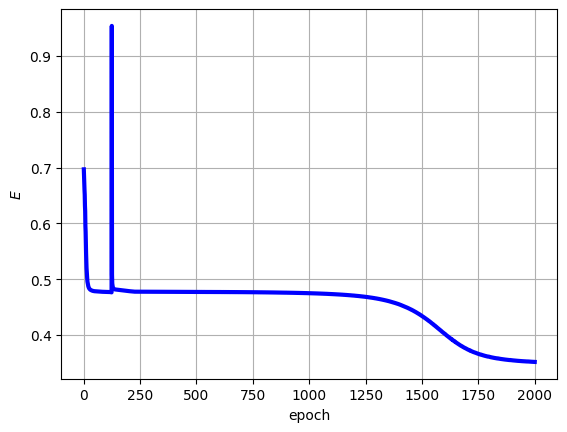

In [10]:
class Model(torch.nn.Module):

    def __init__(self, vocab_size, embedding_size, window_size, hidden_size):
        super().__init__()
        self.window_size = window_size
        
        self.embedding = torch.nn.Embedding(vocab_size, embedding_size)
        self.conv_layer = torch.nn.Conv1d(embedding_size, hidden_size, window_size)
        self.output_layer = torch.nn.Linear(hidden_size, 1)

    def forward(self, x_indexed, text_lens):
        batch_size = x_indexed.shape[0]
        
        embedded = self.embedding(x_indexed)
        embedded_t = embedded.transpose(1, 2)
        hidden_t = torch.nn.functional.leaky_relu(self.conv_layer(embedded_t))
        hidden = hidden_t.transpose(1, 2)
        
        num_windows = max_len - self.window_size + 1
        pad_mask_np = np.ones((batch_size, num_windows, 1), dtype=np.bool_) # Make a 3D mask immediately.
        for i in range(batch_size):
            pad_mask_np[i, :text_lens[i] - self.window_size + 1, :] = False
        pad_mask = torch.tensor(pad_mask_np, device=device)
        masked = hidden.masked_fill(pad_mask, float('inf'))
        
        (pooled, _) = torch.min(masked, dim=1)
        
        return self.output_layer(pooled)

model = Model(len(vocab), embedding_size=2, window_size=2, hidden_size=3)
model.to(device)

optimiser = torch.optim.SGD(model.parameters(), lr=1.0)

print('epoch', 'error')
train_errors = []
for epoch in range(1, 2000+1):
    optimiser.zero_grad()
    logits = model(train_x_indexed, text_lens)
    train_error = torch.nn.functional.binary_cross_entropy_with_logits(logits, train_y)
    train_errors.append(train_error.detach().cpu().tolist())
    train_error.backward()
    optimiser.step()

    if epoch%200 == 0:
        print(epoch, train_errors[-1])
print()

with torch.no_grad():
    print('text', 'output')
    output = torch.sigmoid(model(train_x_indexed, text_lens))[:, 0].cpu().tolist()
    for (text, y) in zip(train_x, output):
        print(text, y)

(fig, ax) = plt.subplots(1, 1)
ax.set_xlabel('epoch')
ax.set_ylabel('$E$')
ax.plot(range(1, len(train_errors) + 1), train_errors, color='blue', linestyle='-', linewidth=3)
ax.grid()

We can check that the pad token is really being ignored by checking the gradients of all the different tokens in the embedding matrix.
Below we're calculating the gradient of the training error with respect to all parameters, extracting the gradients of the embedding matrix, squashing it into a single number per token by taking the absolute sum of each row (each row represents a token), and then checking the result of each row associated with its token.

In [11]:
optimiser.zero_grad()
logits = model(train_x_indexed, text_lens)
train_error = torch.nn.functional.binary_cross_entropy_with_logits(logits, train_y)
train_error.backward()

grads = model.embedding.weight.grad.abs().sum(dim=1).tolist()
for (token, grad) in zip(vocab, grads):
    print(f'{token: >6s}: {grad}')

 <PAD>: 0.0
     .: 0.0011328894179314375
     I: 0.0003101474139839411
 don't: 0.0013983140233904123
  hate: 0.0031053246930241585
    it: 0.0017865784466266632
  like: 0.0011865552514791489


The gradient (or sum of absolute gradients in this case) tells you how **sensitive** the error is to each token in the training set, such that the larger the gradient, the more the error will change if the embedding vector of the token changes.
A gradient of zero means that the error will not change if that embedding vector is changed, which is what we want for the pad token.

## CNNs with parallel convolutions

There's no reason why only one convolution needs to be applied in the same layer.
It is perfectly fine to extract multiple forms of information from the same source and then concatenate the separate vectors together.

![](multiple_convs.png)

This would require creating separate convolution layers for each branch.

In [12]:
num_texts = 2
max_len = 5
embedding_size = 8
num_branches = 2
window_size = 2
hidden_size = 6
assert embedding_size%num_branches == 0 # Embedding size must be divisible by number of branches.
assert hidden_size%num_branches == 0 # Conv layer output size must be divisible by number of branches.

# Create a list of conv layers, each of which takes in and outputs a part of the whole vector.
conv_layers = [
    torch.nn.Conv1d(embedding_size//num_branches, hidden_size//num_branches, window_size)
    for _ in range(num_branches)
]
for layer in conv_layers:
    layer.to(device)

embedded = torch.randn((num_texts, max_len, embedding_size), device=device)
print('embedded:')
print(embedded.shape)
print()

# Break up the embedded tensor into branches.
branched_embedded = [
    embedded[:, :, embedding_size//num_branches*i:embedding_size//num_branches*(i+1)]
    for i in range(num_branches)
]
print('branched_embedded:')
print(*[branch.shape for branch in branched_embedded])
print()

# Perform the convolutional process on each branch.
branched_embedded_t = [
    branched_embedded[i].transpose(1, 2)
    for i in range(num_branches)
]
branched_hidden_t = [
    torch.nn.functional.leaky_relu(conv_layers[i](branched_embedded_t[i]))
    for i in range(num_branches)
]
branched_hidden = [
    branched_hidden_t[i].transpose(1, 2)
    for i in range(num_branches)
]
print('branched_hidden:')
print(*[branch.shape for branch in branched_hidden])
print()

# Concatenate the branches back into one whole.
hidden = torch.cat(branched_hidden, dim=2)
print('hidden:')
print(hidden.shape)
print()

(pooled, _) = torch.min(hidden, dim=1)
print('pooled:')
print(pooled.shape)

embedded:
torch.Size([2, 5, 8])

branched_embedded:
torch.Size([2, 5, 4]) torch.Size([2, 5, 4])

branched_hidden:
torch.Size([2, 4, 3]) torch.Size([2, 4, 3])

hidden:
torch.Size([2, 4, 6])

pooled:
torch.Size([2, 6])


Let's create a multibranch convolutional neural network.

In [13]:
train_x = [
    'I like it .'.split(' '),
    'I hate it .'.split(' '),
    'I don\'t hate it .'.split(' '),
    'I don\'t like it .'.split(' '),
]
train_y = torch.tensor([
    [1],
    [0],
    [1],
    [0],
], dtype=torch.float32, device=device)

text_lens = [len(text) for text in train_x]
print('text_lens:', text_lens)

max_len = max(text_lens)
print('max_len:', max_len)

vocab = ['<PAD>'] + sorted({token for text in train_x for token in text})
token2index = {t: i for (i, t) in enumerate(vocab)}
pad_index = token2index['<PAD>']
print('vocab:', vocab)
print()

train_x_indexed_np = np.full((len(train_x), max_len), pad_index, np.int64)
for i in range(len(train_x)):
    for j in range(len(train_x[i])):
        train_x_indexed_np[i, j] = token2index[train_x[i][j]]
train_x_indexed = torch.tensor(train_x_indexed_np, device=device)
print('train_x_indexed:')
print(train_x_indexed)

text_lens: [4, 4, 5, 5]
max_len: 5
vocab: ['<PAD>', '.', 'I', "don't", 'hate', 'it', 'like']

train_x_indexed:
tensor([[2, 6, 5, 1, 0],
        [2, 4, 5, 1, 0],
        [2, 3, 4, 5, 1],
        [2, 3, 6, 5, 1]])


epoch error
200 0.47681424021720886
400 0.4753340184688568
600 0.47193825244903564
800 0.46259039640426636
1000 0.45813748240470886
1200 0.01376353483647108
1400 0.0037368021439760923
1600 0.002135838381946087
1800 0.001490132068283856
2000 0.0011424344265833497

text output
['I', 'like', 'it', '.'] 0.9999173879623413
['I', 'hate', 'it', '.'] 2.0143513857419906e-17
['I', "don't", 'hate', 'it', '.'] 0.9999371767044067
['I', "don't", 'like', 'it', '.'] 0.004409343004226685


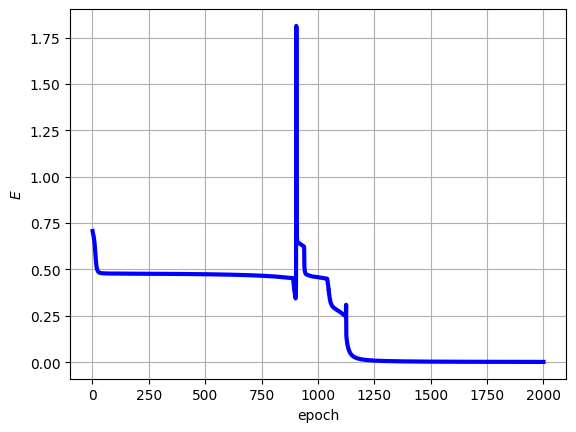

In [14]:
class Model(torch.nn.Module):

    def __init__(self, vocab_size, embedding_size, window_size, num_branches, hidden_size):
        super().__init__()
        assert embedding_size%num_branches == 0
        assert hidden_size%num_branches == 0
        self.embedding_size = embedding_size
        self.window_size = window_size
        
        self.embedding_layer = torch.nn.Embedding(vocab_size, embedding_size)
        self.conv_layers = torch.nn.ModuleList([ # Lists of layers need to be put in a ModuleList object to be part of the module.
            torch.nn.Conv1d(embedding_size//num_branches, hidden_size//num_branches, window_size)
            for _ in range(num_branches)
        ])
        self.output_layer = torch.nn.Linear(hidden_size, 1)

    def forward(self, x_indexed, lens):
        num_branches = len(self.conv_layers)
        batch_size = x_indexed.shape[0]
        
        embedded = self.embedding_layer(x_indexed)

        branched_embedded = [
            embedded[:, :, self.embedding_size//num_branches*i:self.embedding_size//num_branches*(i+1)]
            for i in range(num_branches)
        ]

        branched_embedded_t = [
            branched_embedded[i].transpose(1, 2)
            for i in range(num_branches)
        ]
        branched_hidden_t = [
            torch.nn.functional.leaky_relu(self.conv_layers[i](branched_embedded_t[i]))
            for i in range(num_branches)
        ]
        branched_hidden = [
            branched_hidden_t[i].transpose(1, 2)
            for i in range(num_branches)
        ]
        
        hidden = torch.cat(branched_hidden, dim=2)
        
        num_windows = max_len - self.window_size + 1
        pad_mask_np = np.ones((batch_size, num_windows, 1), dtype=np.bool_)
        for i in range(batch_size):
            pad_mask_np[i, :lens[i] - self.window_size + 1, :] = False
        pad_mask = torch.tensor(pad_mask_np, device=device)
        masked = hidden.masked_fill(pad_mask, float('inf'))
        
        pooled = torch.min(masked, dim=1)[0]
        
        return self.output_layer(pooled)

model = Model(len(vocab), embedding_size=4, window_size=2, num_branches=2, hidden_size=4)
model.to(device)

optimiser = torch.optim.SGD(model.parameters(), lr=1.0)

print('epoch', 'error')
train_errors = []
for epoch in range(1, 2000+1):
    optimiser.zero_grad()
    logits = model(train_x_indexed, text_lens)
    train_error = torch.nn.functional.binary_cross_entropy_with_logits(logits, train_y)
    train_errors.append(train_error.detach().cpu().tolist())
    train_error.backward()
    optimiser.step()

    if epoch%200 == 0:
        print(epoch, train_errors[-1])
print()

with torch.no_grad():
    print('text', 'output')
    output = torch.sigmoid(model(train_x_indexed, text_lens))[:, 0].cpu().tolist()
    for (text, y) in zip(train_x, output):
        print(text, y)

(fig, ax) = plt.subplots(1, 1)
ax.set_xlabel('epoch')
ax.set_ylabel('$E$')
ax.plot(range(1, len(train_errors) + 1), train_errors, color='blue', linestyle='-', linewidth=3)
ax.grid()

## Exercises

### 1) Using convolutional layers

Rewrite the movie reviews classification program using a CNN.
Use 2 parallel convolutional layers with a window size of 2, and a min or max pooling layer after that.
Preprocessing has ben done for you.
Don't forget to calculate the test set accuracy after training.

In [15]:
min_freq = 3

train_df = pd.read_csv('../data_set/sentiment/train.csv')
test_df = pd.read_csv('../data_set/sentiment/test.csv')

train_x = train_df['text']
train_y = train_df['class']
test_x = test_df['text']
test_y = test_df['class']
categories = ['neg', 'pos']
cat2idx = {cat: i for (i, cat) in enumerate(categories)}

train_y_indexed = torch.tensor(
    train_y.map(cat2idx.get).to_numpy()[:, None],
    dtype=torch.float32, device=device
)
test_y_indexed = test_y.map(cat2idx.get).to_numpy()[:, None]

nltk.download('punkt')
train_x_tokens = [nltk.word_tokenize(text) for text in train_x]
test_x_tokens = [nltk.word_tokenize(text) for text in test_x]
train_lens = [len(text) for text in train_x_tokens]
test_lens = [len(text) for text in test_x_tokens]
max_len = max(max(train_lens), max(test_lens))

frequencies = collections.Counter(token for text in train_x_tokens for token in text)
vocabulary = sorted(frequencies.keys(), key=frequencies.get, reverse=True)
while frequencies[vocabulary[-1]] < min_freq:
    vocabulary.pop()
vocab = ['<PAD>', '<UNK>'] + vocabulary
token2index = {token: i for (i, token) in enumerate(vocab)}
pad_index = token2index['<PAD>']
unk_index = token2index['<UNK>']

train_x_indexed_np = np.full((len(train_x_tokens), max_len), pad_index, np.int64)
for i in range(len(train_x_tokens)):
    for j in range(len(train_x_tokens[i])):
        train_x_indexed_np[i, j] = token2index.get(train_x_tokens[i][j], unk_index)
train_x_indexed = torch.tensor(train_x_indexed_np, device=device)

test_x_indexed_np = np.full((len(test_x_tokens), max_len), pad_index, np.int64)
for i in range(len(test_x_tokens)):
    for j in range(len(test_x_tokens[i])):
        test_x_indexed_np[i, j] = token2index.get(test_x_tokens[i][j], unk_index)
test_x_indexed = torch.tensor(test_x_indexed_np, device=device)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [17]:
class Model(torch.nn.Module):

    def __init__(self, vocab_size, embedding_size, window_size, num_branches, hidden_size):
        super().__init__()
        assert embedding_size%num_branches == 0
        assert hidden_size%num_branches == 0
        self.embedding_size = embedding_size
        self.window_size = window_size
        
        self.embedding_layer = torch.nn.Embedding(vocab_size, embedding_size)
        self.conv_layers = torch.nn.ModuleList([ # Lists of layers need to be put in a ModuleList object to be part of the module.
            torch.nn.Conv1d(embedding_size//num_branches, hidden_size//num_branches, window_size)
            for _ in range(num_branches)
        ])
        self.output_layer = torch.nn.Linear(hidden_size, 1)

    def forward(self, x_indexed, lens):
        num_branches = len(self.conv_layers)
        batch_size = x_indexed.shape[0]
        
        embedded = self.embedding_layer(x_indexed)

        branched_embedded = [
            embedded[:, :, self.embedding_size//num_branches*i:self.embedding_size//num_branches*(i+1)]
            for i in range(num_branches)
        ]

        branched_embedded_t = [
            branched_embedded[i].transpose(1, 2)
            for i in range(num_branches)
        ]
        branched_hidden_t = [
            torch.nn.functional.leaky_relu(self.conv_layers[i](branched_embedded_t[i]))
            for i in range(num_branches)
        ]
        branched_hidden = [
            branched_hidden_t[i].transpose(1, 2)
            for i in range(num_branches)
        ]
        
        hidden = torch.cat(branched_hidden, dim=2)
        
        num_windows = max_len - self.window_size + 1
        pad_mask_np = np.ones((batch_size, num_windows, 1), dtype=np.bool_)
        for i in range(batch_size):
            pad_mask_np[i, :lens[i] - self.window_size + 1, :] = False
        pad_mask = torch.tensor(pad_mask_np, device=device)
        masked = hidden.masked_fill(pad_mask, float('inf'))
        
        pooled = torch.min(masked, dim=1)[0]
        
        return self.output_layer(pooled)

model = Model(len(vocab), embedding_size=4, window_size=2, num_branches=2, hidden_size=4)
model.to(device)

optimiser = torch.optim.SGD(model.parameters(), lr=1.0)

print('epoch', 'error')
train_errors = []
for epoch in range(1, 2000+1):
    optimiser.zero_grad()
    logits = model(train_x_indexed, train_lens)
    train_error = torch.nn.functional.binary_cross_entropy_with_logits(logits, test_y_indexed)
    train_errors.append(train_error.detach().cpu().tolist())
    train_error.backward()
    optimiser.step()

    if epoch%200 == 0:
        print(epoch, train_errors[-1])
print()

with torch.no_grad():
    outputs = model(test_x_indexed, test_lens)[:,0].round(decimal=0).cpu().tolist()
    accuracy = sklearn.metrics.accuracy_score(outputs, test_y_indexed)
    print(f'accuracy: {accuracy:.3%}')

(fig, ax) = plt.subplots(1, 1)
ax.set_xlabel('epoch')
ax.set_ylabel('$E$')
ax.plot(range(1, len(train_errors) + 1), train_errors, color='blue', linestyle='-', linewidth=3)
ax.grid()

epoch error


TypeError: 'int' object is not callable